Please note that only the 2nd cell code needs to be executed, not the 1st code cell; As that is training code, so can directly run the 2nd code cell; and there are 4 files required to be uploaded in the colab before running any below of the codes. Those are math-problem-captcha-images.zip, captcha-version-2-images.zip, characters_math.pkl & ocr_captv1_epoch40_math.pth
Although in the below code after training, the pkl & pth file get auto downloaded, but in case of runtime disconnect, they may get lost and the 2nd code can't run without those files present in the colab files. So we'll submit the 4 files, out of which 2 zips
are to be pre-uploaded in the colab files, while the other 2 files also need to be if not running the first code cell for training; which is not necessary to run, but in that case, pre-upload all the 4 files for running the 2nd code cell.

In [ ]:
# 1. Install dependencies
!pip install torch torchvision opencv-python-headless matplotlib --quiet
!pip install -q Pillow kokoro>=0.9.2 soundfile gradio
!apt-get -qq install espeak-ng

# 2. Seed for reproducibility
def seed_everything(seed=42):
    import random, numpy as np, torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
seed_everything()

# 3. Imports
import os, torch, random
import numpy as np
from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt

# 4. Download & Merge Multiple Diverse CAPTCHA Datasets
# Download arithmetic: https://www.kaggle.com/datasets/daniilnxy/math-problem-captcha-images
# Download mix: https://www.kaggle.com/datasets/fournierp/captcha-version-2-images

# Arithmetic
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip -d ./captcha_merge/
# Add arithmetic captchas: (run once downloaded and unzipped!)
!unzip -qq math-problem-captcha-images.zip -d ./captcha_merge/
!unzip -qq captcha-version-2-images.zip -d ./captcha_merge/
# Extend for your use: just put all .png/.jpg images into ./captcha_merge/

data_dirs = [
    Path('./captcha_merge/captcha_images_v2/'),
    Path('./captcha_merge/images/'), # arithmetic math-problem-captcha-images subfolder
    Path('./captcha_merge/captcha_v2/'), # captcha-version-2-images subfolder
]

from glob import glob

def all_images_labels_rec(base_dirs):
    images, labels = [], []
    for base in base_dirs:
        # Find all .png and .jpg recursively in subdirs
        pngs = glob(str(base / '**/*.png'), recursive=True)
        jpgs = glob(str(base / '**/*.jpg'), recursive=True)
        imgs = sorted(pngs + jpgs)
        images.extend(imgs)
        labels.extend([os.path.splitext(os.path.basename(img))[0] for img in imgs])
    return images, labels

data_dirs = [
    Path('./captcha_merge/captcha_images_v2/'),
    Path('./captcha_merge/'),  # This covers all subdirs from all zips!
]

images, labels = all_images_labels_rec(data_dirs)


# Filter out too short/empty labels
cleaned = [(i, l) for i, l in zip(images, labels) if len(l) >= 3 and not l.lower().startswith("readme")]
images, labels = [x[0] for x in cleaned], [x[1] for x in cleaned]

# Build character set: includes + - = explicitly
characters = sorted(set(c for l in labels for c in l) | set("+-="))
print(f"Loaded {len(images)} images, {len(characters)} unique characters.")

# Save mapping for future inference
import pickle
with open('characters_math.pkl', 'wb') as f:
    pickle.dump(characters, f)
char_to_idx = {ch: i for i, ch in enumerate(characters)}
idx_to_char = {i: ch for ch, i in char_to_idx.items()}

# 5. Dataset class
class CaptchaDataset(Dataset):
    def __init__(self, images, labels, char_to_idx, transform=None, augment=False):
        self.images = images
        self.labels = labels
        self.char_to_idx = char_to_idx
        self.transform = transform
        self.augment = augment
        self.train_aug = transforms.Compose([
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomAffine(5, translate=(0.055,0.055)),
        ]) if augment else None

    def __len__(self): return len(self.images)
    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("L")
        label = self.labels[idx]
        if self.augment and self.train_aug:
            img = self.train_aug(img)
        if self.transform:
            img = self.transform(img)
        target = torch.tensor([self.char_to_idx[c] for c in label if c in self.char_to_idx], dtype=torch.long)
        return img, target, label

transform = transforms.Compose([
    transforms.Resize((50,200)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Huge dataset, with augment only in train set!
full_dataset = CaptchaDataset(images, labels, char_to_idx, transform=transform)
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_imgs, val_imgs = images[:train_size], images[train_size:]
train_labels, val_labels = labels[:train_size], labels[train_size:]

train_dataset = CaptchaDataset(train_imgs, train_labels, char_to_idx, transform=transform, augment=True)
val_dataset = CaptchaDataset(val_imgs, val_labels, char_to_idx, transform=transform, augment=False)

# 6. DataLoader and batch collation for variable length targets
def collate_fn(batch):
    imgs, targets, labels = zip(*batch)
    imgs = torch.stack(imgs)
    target_lens = [len(t) for t in targets]
    targets = torch.cat(targets)
    return imgs, targets, target_lens, labels

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, num_workers=2)

# 7. CRNN Model Definition
import torch.nn as nn

class CRNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1,64,3,1,1), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,1,1), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(128,256,3,1,1), nn.ReLU(),
            nn.Conv2d(256,256,3,1,1), nn.ReLU(), nn.MaxPool2d((2,1),(2,1)),
            nn.Conv2d(256,512,3,1,1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512,512,3,1,1), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d((2,1),(2,1)),
            nn.Conv2d(512,512,2,1,0), nn.ReLU()
        )
        self.lstm = nn.LSTM(512*2, 256, num_layers=2, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        b,c,h,w = x.size()
        x = x.view(b,w,c*h)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CRNN(len(characters)+1).to(device)

# 8. Loss and optimizer
criterion = nn.CTCLoss(blank=len(characters))
optimizer = torch.optim.Adam(model.parameters(), lr=8e-5, weight_decay=1e-5)

# 9. Training-validation/loop, loss, decoder
def train_one_epoch(model, loader, opt, device):
    model.train()
    epoch_loss = 0
    for imgs, tgts, tgt_lens, _ in loader:
        imgs, tgts = imgs.to(device), tgts.to(device)
        opt.zero_grad()
        outs = model(imgs).log_softmax(2)
        input_lens = torch.full((outs.size(0),), outs.size(1), dtype=torch.long)
        loss = criterion(outs.permute(1, 0, 2), tgts, input_lens, torch.tensor(tgt_lens))
        loss.backward()
        opt.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def validate(model, loader, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, tgts, tgt_lens, _ in loader:
            imgs, tgts = imgs.to(device), tgts.to(device)
            outs = model(imgs).log_softmax(2)
            input_lens = torch.full((outs.size(0),), outs.size(1), dtype=torch.long)
            loss = criterion(outs.permute(1, 0, 2), tgts, input_lens, torch.tensor(tgt_lens))
            val_loss += loss.item()
    return val_loss / len(loader)

def greedy_decoder(output):
    argmaxes = torch.argmax(output, 2)
    decodes = []
    for i in range(argmaxes.size(0)):
        decode, prev = [], -1
        for j in range(argmaxes.size(1)):
            ix = argmaxes[i, j].item()
            if ix != prev and ix != len(characters):
                decode.append(idx_to_char[ix])
            prev = ix
        decodes.append("".join(decode))
    return decodes

# 10. Training runner with save on epoch 10 & chars.pkl
from google.colab import files
optimizer = torch.optim.Adam(model.parameters(), lr=8e-5, weight_decay=1e-5)

for epoch in range(1, 41):  # Only 10 epochs for demo/experiment
    tr_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_loss = validate(model, val_loader, device)
    print(f"Epoch {epoch}: train loss={tr_loss:.3f}, val loss={val_loss:.3f}")

    # Save best model and mapping file
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"ocr_captv1_epoch{epoch}_math.pth")
        print("Saved model weights after 10 epochs.")
        files.download(f"ocr_captv1_epoch{epoch}_math.pth")

files.download("characters_math.pkl")


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8863k  100 8863k    0     0  5733k      0  0:00:01  0:00:01 --:--:-- 5733k
Loaded 20412 images, 25 unique characters.
Epoch 1: train loss=3.191, val loss=3.262
Epoch 2: train loss=2.253, val loss=3.193
Epoch 3: train loss=1.563, val loss=3.128
Epoch 4: train loss=1.081, val loss=2.980
Epoch 5: train loss=0.747, val loss=2.724
Epoch 6: train loss=0.535, val loss=2.199
Epoch 7: train loss=0.414, val loss=1.957
Epoch 8: train loss=0.343, val loss=1.753
Epoch 9: train loss=0.295, val loss=1.580
Epoch 10: train loss=0.249, val loss=1.338
Saved model weights after 10 epochs.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 11: train loss=0.220, val loss=1.168
Epoch 12: train loss=0.191, val loss=0.957
Epoch 13: train loss=0.164, val loss=0.778
Epoch 14: train loss=0.138, val loss=0.619
Epoch 15: train loss=0.117, val loss=0.492
Epoch 16: train loss=0.105, val loss=0.457
Epoch 17: train loss=0.094, val loss=0.336
Epoch 18: train loss=0.077, val loss=0.298
Epoch 19: train loss=0.068, val loss=0.211
Epoch 20: train loss=0.060, val loss=0.180
Saved model weights after 10 epochs.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 21: train loss=0.056, val loss=0.169
Epoch 22: train loss=0.052, val loss=0.116
Epoch 23: train loss=0.042, val loss=0.120
Epoch 24: train loss=0.044, val loss=0.108
Epoch 25: train loss=0.046, val loss=0.086
Epoch 26: train loss=0.036, val loss=0.071
Epoch 27: train loss=0.030, val loss=0.102
Epoch 28: train loss=0.033, val loss=0.064
Epoch 29: train loss=0.030, val loss=0.057
Epoch 30: train loss=0.035, val loss=0.054
Saved model weights after 10 epochs.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 31: train loss=0.025, val loss=0.040
Epoch 32: train loss=0.029, val loss=0.049
Epoch 33: train loss=0.025, val loss=0.042
Epoch 34: train loss=0.030, val loss=0.033
Epoch 35: train loss=0.021, val loss=0.037
Epoch 36: train loss=0.021, val loss=0.036
Epoch 37: train loss=0.019, val loss=0.032
Epoch 38: train loss=0.020, val loss=0.037
Epoch 39: train loss=0.022, val loss=0.040
Epoch 40: train loss=0.025, val loss=0.037
Saved model weights after 10 epochs.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

replace ./all_captchas/captcha_images_v2/ydd3g.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace ./all_captchas/math_problem_captcha_datt.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace ./all_captchas/samples/226md.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Total images found: 19372
all_captchas/math_problems_captcha_dt: 16192 images found
all_captchas/captcha_images_v2: 1040 images found
all_captchas/samples: 2140 images found
Loaded 19372 images with 25 unique characters (from pkl).
Predicted text: 101+76


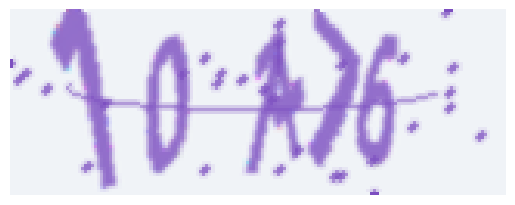

Predicted text (before TTS): 2356g


2356g


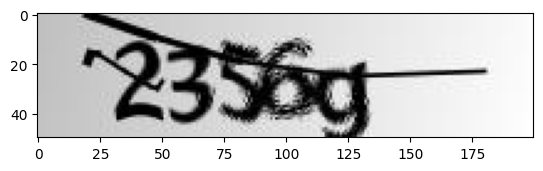

In [ ]:
# --- 1. Install dependencies ---
!pip install torch torchvision opencv-python-headless matplotlib --quiet
!pip install -q Pillow kokoro>=0.9.2 soundfile

# --- 2. Unzip ALL datasets into one location (run this once after uploading all three zips) ---
!unzip -qq captcha_images_v2.zip -d ./all_captchas/
!unzip -qq math-problem-captcha-images.zip -d ./all_captchas/
!unzip -qq captcha-version-2-images.zip -d ./all_captchas/

# --- 3. Seed for reproducibility ---
def seed_everything(seed=42):
    import random, numpy as np, torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
seed_everything()

# --- 4. Imports ---
import os
import torch
import numpy as np
from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from glob import glob

# --- 5. Recursively Load ALL images from ./all_captchas/ ---
base_dir = Path('./all_captchas')
pngs = glob(str(base_dir / '**' / '*.png'), recursive=True)
jpgs = glob(str(base_dir / '**' / '*.jpg'), recursive=True)
images = sorted(pngs + jpgs)
labels = [os.path.splitext(os.path.basename(img))[0] for img in images]

print("Total images found:", len(images))
# Optional: Check count from each main folder
for sub in base_dir.glob('*'):
    if sub.is_dir():
        count = len(list(sub.glob('**/*.png'))) + len(list(sub.glob('**/*.jpg')))
        print(f"{sub}: {count} images found")

# --- 6. LOAD your saved characters.pkl mapping ---
import pickle
with open('characters_math.pkl', 'rb') as f:
    characters = pickle.load(f)
char_to_idx = {ch: i for i, ch in enumerate(characters)}
idx_to_char = {i: ch for ch, i in char_to_idx.items()}

print(f"Loaded {len(images)} images with {len(characters)} unique characters (from pkl).")

# --- 7. Dataset Class (no cropping, whole image) ---
class CaptchaDataset(Dataset):
    def __init__(self, images, labels, char_to_idx, transform=None):
        self.images = images
        self.labels = labels
        self.char_to_idx = char_to_idx
        self.transform = transform
    def __len__(self): return len(self.images)
    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("L")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        target = torch.tensor([self.char_to_idx[c] for c in label if c in self.char_to_idx], dtype=torch.long)
        return img, target, label

transform = transforms.Compose([
    transforms.Resize((50, 200)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = CaptchaDataset(images, labels, char_to_idx, transform=transform)

# --- 8. CRNN Model (same arch as training) ---
import torch.nn as nn
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(), nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(512, 512, 2, 1, 0), nn.ReLU()
        )
        self.lstm = nn.LSTM(512 * 2, 256, num_layers=2, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(512, num_classes)
    def forward(self, x):
        x = self.cnn(x)
        b, c, h, w = x.size()
        x = x.view(b, w, c * h)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

# --- 9. Restore model weights ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CRNN(len(characters) + 1).to(device)
model.load_state_dict(torch.load("ocr_captv1_epoch40_math.pth", map_location=device))
model.eval()

# --- 10. Decoder and Inference Utility ---
def greedy_decoder(output):
    argmaxes = torch.argmax(output, 2)
    decodes = []
    for i in range(argmaxes.size(0)):
        decode, prev = [], -1
        for j in range(argmaxes.size(1)):
            ix = argmaxes[i, j].item()
            if ix != prev and ix != len(characters):
                decode.append(idx_to_char[ix])
            prev = ix
        decodes.append("".join(decode))
    return decodes

def predict_image_text(model, img_path=None, img_arr=None):
    if img_arr is not None:
        img = Image.fromarray(img_arr).convert("L") if isinstance(img_arr, np.ndarray) else img_arr
    elif img_path is not None:
        img = Image.open(img_path).convert("L")
    else:
        raise ValueError("Provide either img_path or img_arr.")
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(img_tensor).log_softmax(2)
        pred = greedy_decoder(out.cpu())[0]
    return pred

# --- 11. Test on a random sample ---
sample_num = 1510
sample_path = images[sample_num]
print("Predicted text:", predict_image_text(model, img_path=sample_path))
plt.imshow(Image.open(sample_path)); plt.axis('off'); plt.show()

# --- 12. TTS with kokoro (unchanged) ---
!pip install -q kokoro>=0.9.2 soundfile
!apt-get -qq -y install espeak-ng > /dev/null 2>&1
from kokoro import KPipeline
from IPython.display import display, Audio
import soundfile as sf

pipeline = KPipeline(lang_code='a')

class OCR_TTS:
    def __init__(self, model, idx_to_char, characters, pipeline):
        self.model = model
        self.idx_to_char = idx_to_char
        self.characters = characters
    def image_to_text(self, img_path):
        pred = predict_image_text(self.model, img_path=img_path)
        print("Predicted text (before TTS):", pred)
        return pred
    def text_to_speech(self, text):
        try:
            generator = pipeline(text, voice='af_heart')
            for i, (gs, ps, audio) in enumerate(generator):
                display(Audio(data=audio, rate=24000, autoplay=i == 0))
                sf.write(f'{i}.wav', audio, 24000)
        except ImportError:
            print("Kokoro TTS not installed. Returning text only.")
    def image_to_speech(self, img_path):
        img = Image.open(img_path)
        plt.imshow(img)
        text = self.image_to_text(img_path)
        self.text_to_speech(text)
        return text

ocr_tts = OCR_TTS(model, idx_to_char, characters, pipeline)
print(ocr_tts.image_to_speech(images[2]))
